In [57]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv', index_col = 'id')
test = pd.read_csv('test.csv', index_col = 'id')

In [58]:
train.head()

,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating
id,,,,,,,,,,
0,Forastera,https://images.gr-assets.com/books/1500683049l...,"Recién acabada la Segunda Guerra Mundial, una ...",Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,Kindle Edition,768 pages,40197,668892,4.22
1,Writing about Magic,https://images.gr-assets.com/books/1445900480l...,Do you write fantasy fiction? This book is a r...,Language|Writing|Nonfiction,Rayne Hall,Paperback,180 pages,27,126,3.95
2,The Stress of Her Regard,https://images.gr-assets.com/books/1503059955l...,When Michael Crawford discovers his bride brut...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,Paperback,470 pages,331,3626,3.79
3,The Horrors and Absurdities of Religion,https://images.gr-assets.com/books/1409779869l...,"A fascinating examination of ethics, religion ...",Philosophy|Religion|Nonfiction|Classics,Arthur Schopenhauer,Paperback,106 pages,28,371,3.85
4,Three Tales,https://images.gr-assets.com/books/1311645483l...,"First published in 1877, these three stories a...",Fiction|Short Stories|Classics|Cultural|France...,Gustave Flaubert|Roger Whitehouse|Geoffrey Wall,Paperback,110 pages,250,4331,3.72


In [59]:
## Encoding names with tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
titles_train = vectorizer.fit_transform(train.book_title)
titles_test = vectorizer.transform(test.book_title)

In [60]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=60)
pca = pca.fit(titles_train)

In [61]:
features_train_title = pd.DataFrame(pca.transform(titles_train), columns = ['title_'+str(i) for i in range(60)])
features_test_title = pd.DataFrame(pca.transform(titles_test), columns = ['title_'+str(i) for i in range(60)])

### Ideas: 
- categorical features - Maks
- similarity of title/desk
- aggregate features of book_genre, book_authors, book_format - Maks
- розширення фіч
- скорочення тренувального датасету та відкидання аутлаєрів
- id (може бути якась часова залежність)
- якість картинок (всім похуй шо там, а от якість важлива)

- шо відрізняє семпли в яких нулі в таргеті!!!!
- йобнуть кросвалідацію



### Working with text features

In [62]:
import pickle

with open('embeddings.pickle', 'rb') as handle:
    b = pickle.load(handle)

X = b['embs_text_train']
Xt = b['embs_text_test']

from sklearn.decomposition import PCA
pca = PCA(n_components=60)
pca = pca.fit(X)

features_train = pd.DataFrame(pca.transform(X), columns = ['text_'+str(i) for i in range(60)])
features_test = pd.DataFrame(pca.transform(Xt), columns = ['text_'+str(i) for i in range(60)])

In [63]:
import pickle

with open('embeddings.pickle', 'rb') as handle:
    b = pickle.load(handle)

X1 = b['embs_title_train']
Xt1 = b['embs_title_test']

from sklearn.decomposition import PCA
pca = PCA(n_components=60)
pca = pca.fit(X)

features_train_tit = pd.DataFrame(pca.transform(X1), columns = ['tit_'+str(i) for i in range(60)])
features_test_tit = pd.DataFrame(pca.transform(Xt1), columns = ['tit_'+str(i) for i in range(60)])

In [64]:
sim = [(X[i].dot(X1[i]))/np.linalg.norm(X[i])/np.linalg.norm(X1[i]) for i in range(len(X))]
simt = [(Xt[i].dot(Xt1[i]))/np.linalg.norm(Xt[i])/np.linalg.norm(Xt1[i]) for i in range(len(Xt))]

# Modelling

In [65]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import copy
from matplotlib import pyplot as plt

train_df = pd.read_csv('train_processed_v2.csv')
test_df = pd.read_csv('test_processed_v2.csv')

In [66]:
train_df = pd.concat([train_df, features_train,  features_train_tit], axis = 1)
test_df = pd.concat([test_df, features_test,  features_test_tit], axis = 1)

train_df['sim'] = sim
test_df['sim'] = simt

In [78]:
features_cat = ['Nonfiction', 'African American', 'Book Club', 'Realistic Fiction', 
                'Retellings', 'Dark', 'Teen', 'Adventure', 'Paranormal', 'Humor', 
                'Young Adult', 'Amazon', 'Asian Literature', 'Audiobook', 'Memoir', 
                'Dystopia', 'Academic', 'Space', 'Detective', 'Novella', 'Horror', 'Race',
                'Novels', 'War', 'Adult Fiction', 'Fantasy', 'Cultural', 'Historical Romance',
                'Urban Fantasy', 'Fiction', 'Magical Realism', 'History', 'Contemporary Romance',
                'Erotica', 'Self Help', 'Food and Drink', 'Coming Of Age', 
                'Books About Books', 'Autobiography', 'New Adult', 'Politics', 
                'European Literature', 'Adult', 'Fairy Tales', 'Womens Fiction',
                'Health', 'Science Fiction Fantasy', 'Mythology', 'Sequential Art', 
                'Romantic Suspense', 'Literature', 'Young Adult Fantasy', 'Childrens', 
                'Short Stories', 'Science', 'Historical', 'Thriller', 'Crime', 'Family', 
                'Sociology', 'Music', 'Biography', 'Psychology', 'Speculative Fiction', 
                'Vampires', 'Magic', 'Middle Grade', 'Historical Fiction', 'Biography Memoir',
                'Writing', 'High School', 'Romance', 'Mystery Thriller', 'Mental Health', 
                'Essays', 'Chick Lit', 'College', 'Sports', 'Witches', 'Graphic Novels', 
                'Paranormal Romance', 'Religion', 'Contemporary', 'Queer', 'Business', 
                'British Literature', 'Feminism', 'Mystery', 'World War II', 'Suspense', 
                'Comics', 'Womens', 'Science Fiction', 'Drama', 'Literary Fiction', 
                'Supernatural', 'Holiday', 'Environment', 'High Fantasy', 'Other_book_genre',
                'Penelope Douglas', 'Holly Black', 'Nora Roberts', 'Jennifer L. Armentrout',
                'Amy Harmon', 'Michael Connelly', 'Lucy Score', 'V.E. Schwab', 'Ilona Andrews', 
                'Jay Kristoff', 'Rainbow Rowell', 'F. Scott Fitzgerald', 'Nalini Singh', 
                'Christina Lauren', 'Seanan McGuire', 'Lauren Layne', 'Krista Ritchie', 
                'Leigh Bardugo', 'Kelley Armstrong', 'Meghan Quinn', 'Lisa Jackson',
                'Jim Butcher', 'Helena Hunting', 'Melissa de la Cruz', 'Maxine Paetro',
                'J.R. Ward', 'Julia Quinn', 'Cassandra Clare', 'Danielle Steel', 'Louise Penny',
                'Rachel Caine', 'James Patterson', 'J.D. Robb', 'Stephen King', 'Marie Lu', 
                'Fredrik Backman', 'John Grisham', 'Vi Keeland', 'Amie Kaufman', 'Meg Cabot',
                'Stuart Woods', 'Jewel E. Ann', 'Becca Ritchie', 'Danielle  Paige', 'Penelope Ward', 
                'C.J. Box', 'L.J. Shen', 'Brandon Sanderson', 'Neil Gaiman', 'Other_book_authors']

In [105]:
features = (['book_pages', 'book_review_count', 'book_rating_count', 'sim', 'image_width', 'image_heigth', 'image_size_product',
            'book_desc_len', 'ratio_review_rating', 'ratio_rating_review'] + features_cat + ['text_'+str(i) for i in range(60)] + ['tit_'+str(i) for i in range(60)])

cat_features = []


target = 'book_rating'


## Catboost  + text features + maksfeatures1 :

In [106]:
from sklearn.model_selection import train_test_split

# features = ['book_pages', 'book_review_count', 'book_rating_count',
#             'book_desc_len', 'ratio_review_rating', 'ratio_rating_review']

# target = 'book_rating'

X = train_df[features]
y = train_df[target]

X.fillna(0, inplace = True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)

/usr/local/anaconda/envs/ntr/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [107]:
X

,book_pages,book_review_count,book_rating_count,sim,image_width,image_heigth,image_size_product,book_desc_len,ratio_review_rating,ratio_rating_review,...,tit_50,tit_51,tit_52,tit_53,tit_54,tit_55,tit_56,tit_57,tit_58,tit_59
0,768,40197,668892,0.244505,475,302,143450,1009,0.060095,16.640346,...,1.058836,-1.022769,0.766387,0.837076,-0.601712,-0.320433,1.134865,-1.317996,0.958993,-0.997728
1,180,27,126,0.599273,475,308,146300,104,0.214286,4.666667,...,-1.481830,1.071251,1.145036,1.499531,0.004934,0.996605,0.648980,0.980145,-0.515200,0.892634
2,470,331,3626,0.054715,475,288,136800,600,0.091285,10.954683,...,0.783680,-0.694699,-0.758347,0.102713,-1.179137,-0.189061,1.108254,-0.042690,0.117523,0.637456
3,106,28,371,0.475776,475,291,138225,688,0.075472,13.250000,...,-1.242860,0.584789,-0.050858,0.825520,0.474965,0.436048,-0.043463,1.071130,0.398436,1.097380
4,110,250,4331,0.373309,280,181,50680,681,0.057723,17.324000,...,0.419682,0.796218,-0.912256,0.532438,-0.404675,0.209832,0.274773,0.155050,0.048089,1.093364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,491,24661,165284,-0.107492,475,297,141075,681,0.149204,6.702242,...,1.071289,-0.351830,1.974561,1.682850,-2.315957,-0.298056,0.632842,-0.106958,-0.536335,-0.066722
39996,48,130,1556,0.052767,400,260,104000,521,0.083548,11.969231,...,0.867860,-0.339519,1.296367,1.542552,0.453604,0.731899,1.520456,-0.498708,-1.846645,-0.121055
39997,416,3,159,0.370324,475,302,143450,827,0.018868,53.000000,...,-0.266215,-1.854161,-0.173068,0.594487,-0.506852,0.084910,0.620649,0.817576,0.784633,0.963147
39998,336,645,2955,0.278950,400,258,103200,421,0.218274,4.581395,...,-1.360825,-0.137149,0.788397,1.199651,-1.715843,-0.725893,-0.465751,-0.815224,0.558086,-1.116836


In [108]:
from catboost import CatBoostRegressor, Pool, cv

def fit_catboost_without_text(X_train, y_train, feature_columns, catboost_params={}):
    
    learn_pool = Pool(
        X_train[feature_columns], 
        y_train,
        cat_features=cat_features,
    )
    
    catboost_default_params = {
        'loss_function': 'RMSE',
        'min_child_samples': 30,
        'learning_rate': 0.03,
        'task_type': 'GPU',
        'random_seed': 42,
        'iterations': 500,
        "verbose": False
    }
    
    catboost_default_params.update(catboost_params)

#     scores = cv(learn_pool,
#                 catboost_default_params,
#                 fold_count=5,
#                 plot="True")
    
    model = CatBoostRegressor(**catboost_default_params)
    model.fit(learn_pool)
    
    return model

model = fit_catboost_without_text(X, y, features, catboost_params={})

In [109]:
{k:v for k,v in zip(model.feature_names_, model.feature_importances_)}

{'book_pages': 5.374796469348567,
 'book_review_count': 6.439721810908712,
 'book_rating_count': 10.23293858066287,
 'sim': 0.07962084999843973,
 'image_width': 0.23318968285632638,
 'image_heigth': 1.2525072925411027,
 'image_size_product': 0.2552699589382816,
 'book_desc_len': 0.2465215470496723,
 'ratio_review_rating': 22.360119157652694,
 'ratio_rating_review': 29.964846248415444,
 'Nonfiction': 0.012102773385662445,
 'African American': 0.23531688436024611,
 'Book Club': 0.0,
 'Realistic Fiction': 0.0,
 'Retellings': 0.0,
 'Dark': 0.04724045614030567,
 'Teen': 0.06705733463004492,
 'Adventure': 0.012920859176556254,
 'Paranormal': 0.18728007647218134,
 'Humor': 0.0,
 'Young Adult': 0.822692532818153,
 'Amazon': 0.0,
 'Asian Literature': 0.022296568828958013,
 'Audiobook': 0.0,
 'Memoir': 0.0,
 'Dystopia': 0.006090755809872351,
 'Academic': 0.356828271545631,
 'Space': 0.0007930645920397829,
 'Detective': 6.644524999342603e-05,
 'Novella': 0.001477425329813359,
 'Horror': 0.2895639

#### predicting phase

In [110]:
name = f'sheet_pit_myk_sran.csv'

pred = pd.DataFrame({'id': test_df.index, 'book_rating': model.predict(test_df[features])})
pred.to_csv(name, index = False)

<AxesSubplot:>

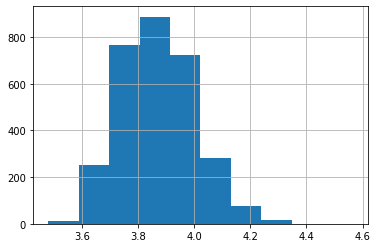

In [111]:
pred.book_rating.hist()

In [112]:
name = f'sheet_pit_myk_sran.csv'

pred = pd.DataFrame({'id': test_df.index, 'book_rating': model.predict(test_df.replace([np.inf, -np.inf], 1)[features])})
pred.to_csv(name, index = False)